# Budowa modeli predykcyjnych cen mieszkań

Ten notatnik koncentruje się na budowie i ocenie modeli uczenia maszynowego do przewidywania cen sprzedaży i wynajmu mieszkań w Polsce. Proces ten opiera się na wnioskach z eksploracyjnej analizy danych (EDA) przeprowadzonej w notatniku `analysis.ipynb`.

Kroki realizowane w tym notatniku:
1.  **Wczytanie i przygotowanie danych**: Załadowanie przetworzonych danych z plików Parquet.
2.  **Transformacje i inżynieria cech**:
    *   Obsługa brakujących wartości.
    *   Transformacja logarytmiczna zmiennej docelowej (`price`).
    *   Tworzenie nowych cech (np. wiek budynku).
    *   Kodowanie zmiennych kategorycznych.
3.  **Budowa i ocena modeli**:
    *   Podział danych na zbiory treningowe i testowe.
    *   Wybór, trening i ocena 5 różnych modeli regresyjnych.
    *   Wizualizacja wyników i kontrola przeuczenia.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import xgboost
from lightgbm import LGBMRegressor
import lightgbm
import joblib
from sklearn.metrics import mean_squared_error, r2_score

# Ustawienia wizualizacji
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)

# Definiowanie ścieżek
input_dir = 'trusted_data'

## 1. Wczytanie i przygotowanie danych (ceny sprzedaży)

Na podstawie wniosków z EDA, wykonujemy następujące kroki:
- Wczytujemy zbiór `apartments_sell.parquet`.
- Logarytmujemy zmienną docelową `price`, aby znormalizować jej rozkład.
- Tworzymy nową cechę `building_age`.
- **Wybieramy cechy do modelu**: do trenowania wykorzystane zostaną wszystkie dostępne kolumny z wyjątkiem `id`, `price`, `price_log` i `buildYear`.
- Dzielimy zbiór na cechy (X) i zmienną docelową (y).

In [2]:

# Wczytanie danych
sell_df = pd.read_parquet(os.path.join(input_dir, 'apartments_sell.parquet'))

# --- Inżynieria i transformacja cech ---

# 1. Logarytmowanie ceny
sell_df['price_log'] = np.log1p(sell_df['price'])

# 2. Obliczenie wieku budynku
current_year = 2024
sell_df['building_age'] = current_year - sell_df['buildYear']

# 3. Definicja zmiennej docelowej i cech
X = sell_df.drop(['id', 'price', 'price_log', 'buildYear'], axis=1)
y = sell_df['price_log']

# Wyświetlenie pierwszych wierszy po transformacji
print("Próbka danych po wstępnej transformacji:")
display(X.head())
print("\nZmienna docelowa (logarytm ceny):")
display(y.head())

Próbka danych po wstępnej transformacji:


,year,month,city,type,squareMeters,rooms,floor,floorCount,latitude,longitude,...,pharmacyDistance,ownership,buildingMaterial,condition,hasParkingSpace,hasBalcony,hasElevator,hasSecurity,hasStorageRoom,building_age
0,2023,9,szczecin,tenement,123.45,4.0,2.0,3.0,53.432586,14.535685,...,0.321,condominium,brick,None,no,yes,no,no,yes,NaN
1,2023,9,szczecin,None,53.80,2.0,5.0,5.0,53.429429,14.554642,...,0.073,cooperative,None,None,no,no,yes,no,no,NaN
2,2023,9,szczecin,tenement,50.00,2.0,NaN,1.0,53.364400,14.660900,...,0.399,condominium,brick,None,yes,no,no,no,no,NaN
3,2023,9,szczecin,blockOfFlats,55.19,2.0,1.0,2.0,53.480364,14.541494,...,0.183,condominium,brick,premium,yes,yes,no,yes,yes,11.0
4,2023,9,szczecin,tenement,73.02,3.0,2.0,3.0,53.452222,14.553333,...,0.280,condominium,brick,None,no,no,no,no,no,NaN



Zmienna docelowa (logarytm ceny):


0    13.591117
1    12.948012
2    12.765691
3    13.316286
4    13.244583
Name: price_log, dtype: float64

## 2. Przetwarzanie wstępne (Preprocessing)

Tworzymy potok (pipeline) do przetwarzania danych, który:
- **Uzupełnia braki w danych**: medianą dla cech numerycznych i modą (najczęstszą wartością) dla cech kategorycznych.
- **Skaluje cechy numeryczne**: używając `StandardScaler`.
- **Koduje cechy kategoryczne**: używając `OneHotEncoder`, ignorując nieznane kategorie napotkane podczas predykcji.

In [ ]:
from sklearn.impute import SimpleImputer

# Identyfikacja typów kolumn
numeric_features = X.select_dtypes(include=np.number).columns.tolist()
categorical_features = X.select_dtypes(exclude=np.number).columns.tolist()

# Tworzenie potoków dla cech numerycznych i kategorycznych
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

# Tworzenie głównego procesora danych
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

# Podział danych na zbiór treningowy i testowy
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Rozmiar zbioru treningowego: {X_train.shape[0]} próbek")
print(f"Rozmiar zbioru testowego: {X_test.shape[0]} próbek")

Rozmiar zbioru treningowego: 156454 próbek
Rozmiar zbioru testowego: 39114 próbek


: 

## 3. Budowa, trening i ocena modeli

Teraz zdefiniujemy, wytrenujemy i ocenimy 5 różnych modeli regresyjnych. Dla każdego z nich:
1.  Stworzymy potok (pipeline) łączący nasz preprocesor z modelem.
2.  Wytrenujemy model na zbiorze treningowym (`X_train`, `y_train`).
3.  Dokonamy predykcji na zbiorze testowym (`X_test`).
4.  Obliczymy kluczowe metryki wydajności: **R² (współczynnik determinacji)** oraz **RMSE (pierwiastek błędu średniokwadratowego)**.

Wybrane modele to:
-   **Linear Regression**: Model bazowy.
-   **Ridge Regression**: Liniowy model z regularyzacją L2.
-   **Random Forest Regressor**: Model zespołowy oparty na drzewach decyzyjnych.
-   **XGBoost Regressor**: Popularny i wydajny model oparty na wzmacnianiu gradientowym.
-   **LightGBM Regressor**: Kolejny wydajny model oparty na wzmacnianiu gradientowym, często szybszy niż XGBoost.

In [ ]:
# Definicja modeli
# Parametry early stopping są przekazywane do konstruktora, gdy model jest w pipeline
models = {
    'Linear Regression': LinearRegression(),
    'Ridge': Ridge(random_state=42),
    'Random Forest': RandomForestRegressor(random_state=42, n_jobs=-1),
    'XGBoost': XGBRegressor(
        random_state=42, 
        n_jobs=-1, 
        early_stopping_rounds=50  # Przekazane do konstruktora
    ),
    'LightGBM': LGBMRegressor(
        random_state=42, 
        n_jobs=-1,
        callbacks=[lightgbm.early_stopping(50, verbose=False)] # Przekazane do konstruktora
    )
}

# Słownik do przechowywania wyników i wytrenowanych potoków
results = {}
trained_pipelines = {}

# Pętla do trenowania i oceny modeli
for name, model in models.items():
    print(f"--- Trenowanie modelu: {name} ---")
    
    # Tworzenie pełnego potoku
    pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('regressor', model)])
    
    # Przygotowanie danych walidacyjnych dla modeli boostingowych
    # Preprocesor musi zostać dopasowany do danych treningowych, a następnie użyty do transformacji danych testowych
    X_test_transformed = preprocessor.fit(X_train, y_train).transform(X_test)
    
    # Trenowanie modelu
    # Dla modeli boostingowych przekazujemy przetworzony eval_set do pipeline.fit
    if name in ['XGBoost', 'LightGBM']:
        pipeline.fit(X_train, y_train, regressor__eval_set=[(X_test_transformed, y_test)])
    else:
        pipeline.fit(X_train, y_train)
    
    # Predykcje na zbiorze testowym
    y_pred = pipeline.predict(X_test)
    
    # Ocena modelu
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    
    # Zapisywanie wyników i wytrenowanego potoku
    results[name] = {'R2': r2, 'RMSE': rmse}
    trained_pipelines[name] = pipeline
    
    print(f"Wyniki dla {name}:")
    print(f"  R²: {r2:.4f}")
    print(f"  RMSE: {rmse:.4f}")

# Konwersja wyników do DataFrame dla łatwiejszego porównania
results_df = pd.DataFrame(results).T.sort_values(by='R2', ascending=False)

print("--- Podsumowanie wyników ---")
display(results_df)


--- Trenowanie modelu: Linear Regression ---


Wyniki dla Linear Regression:
  R²: 0.8478
  RMSE: 0.1879
--- Trenowanie modelu: Ridge ---
Wyniki dla Linear Regression:
  R²: 0.8478
  RMSE: 0.1879
--- Trenowanie modelu: Ridge ---
Wyniki dla Ridge:
  R²: 0.8478
  RMSE: 0.1879
--- Trenowanie modelu: Random Forest ---
Wyniki dla Ridge:
  R²: 0.8478
  RMSE: 0.1879
--- Trenowanie modelu: Random Forest ---


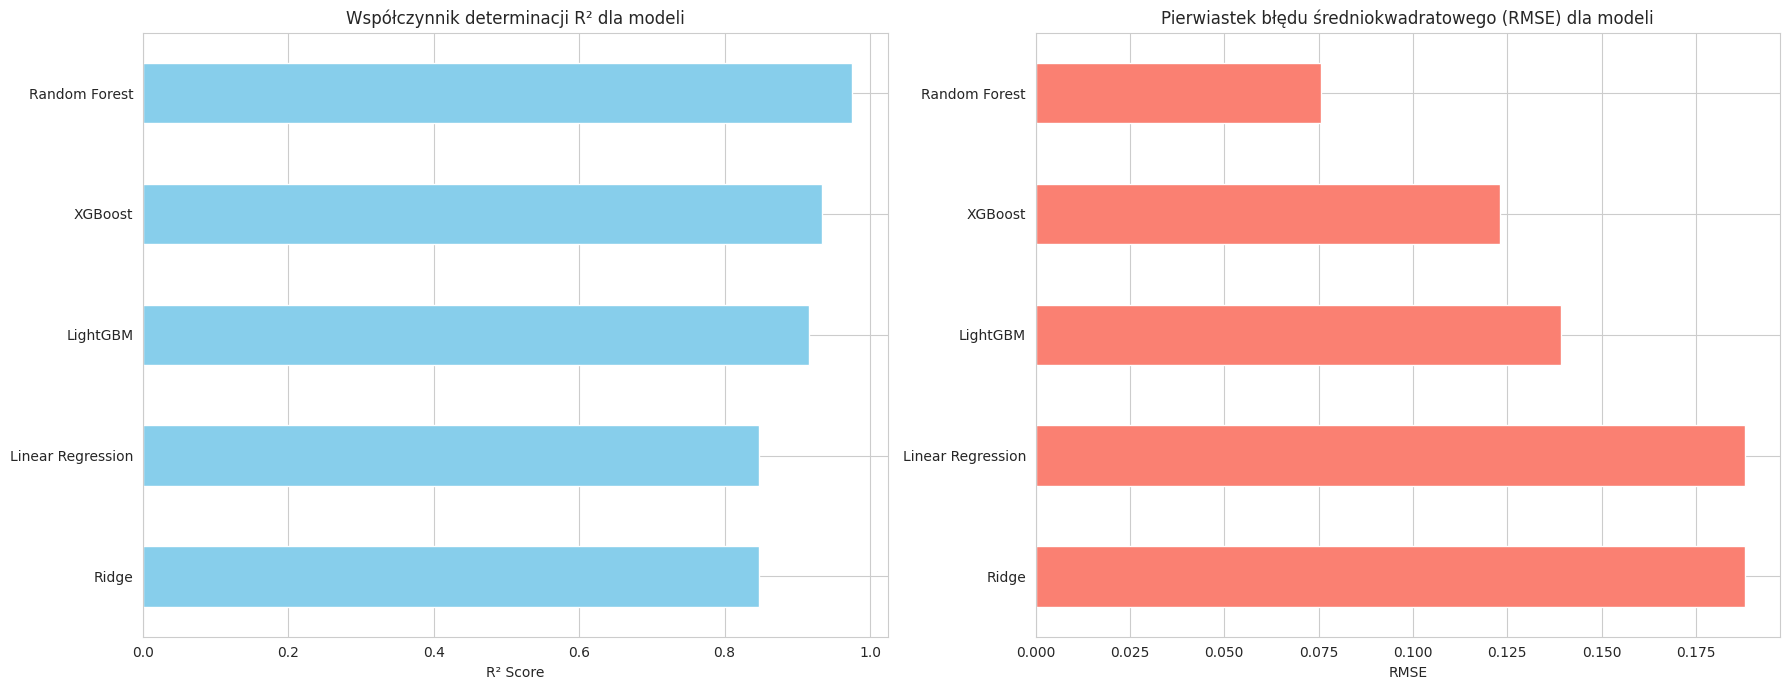

--- Analiza modelu: Linear Regression ---


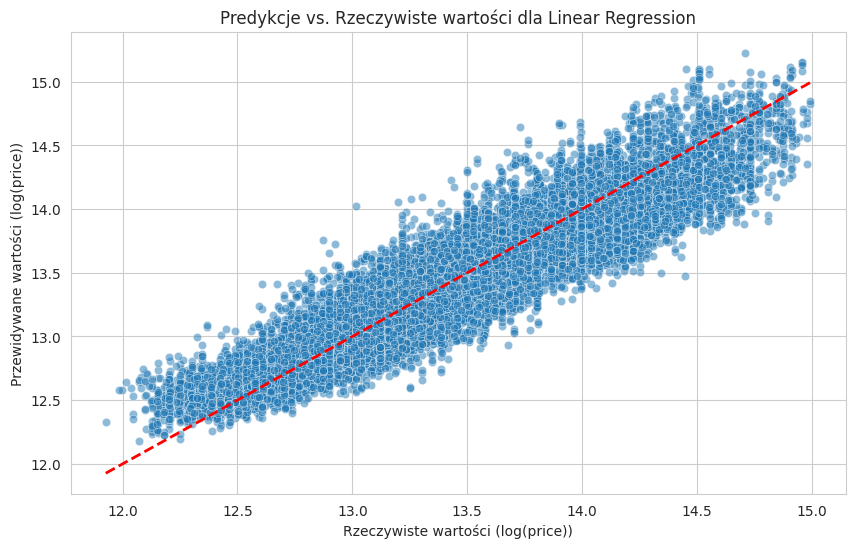

--------------------

--- Analiza modelu: Ridge ---


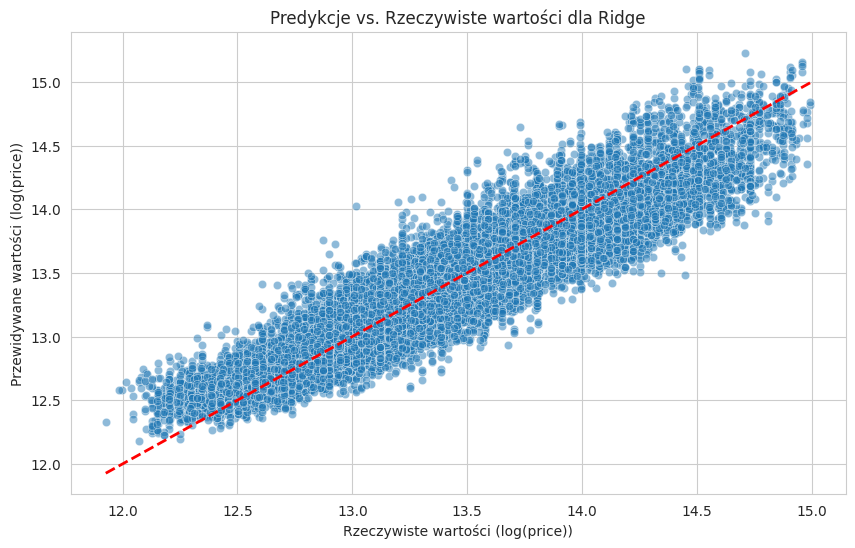

--------------------

--- Analiza modelu: Random Forest ---


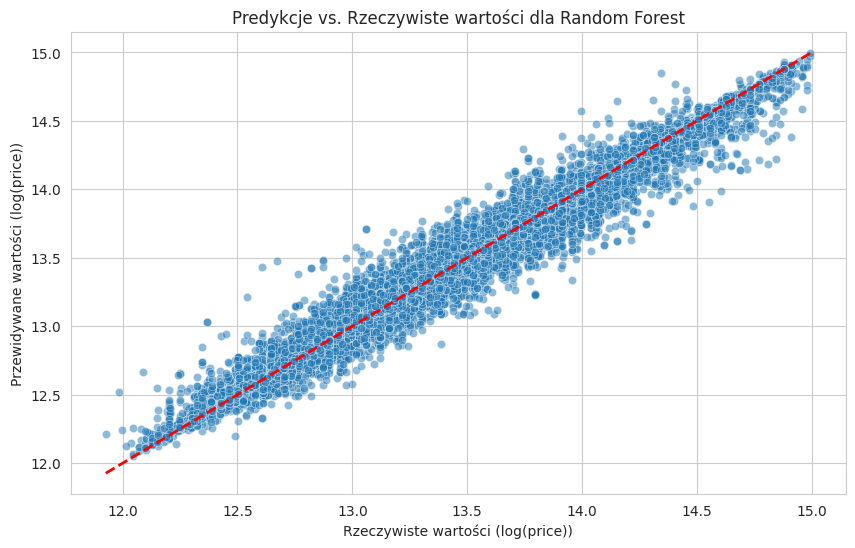

--------------------

--- Analiza modelu: XGBoost ---


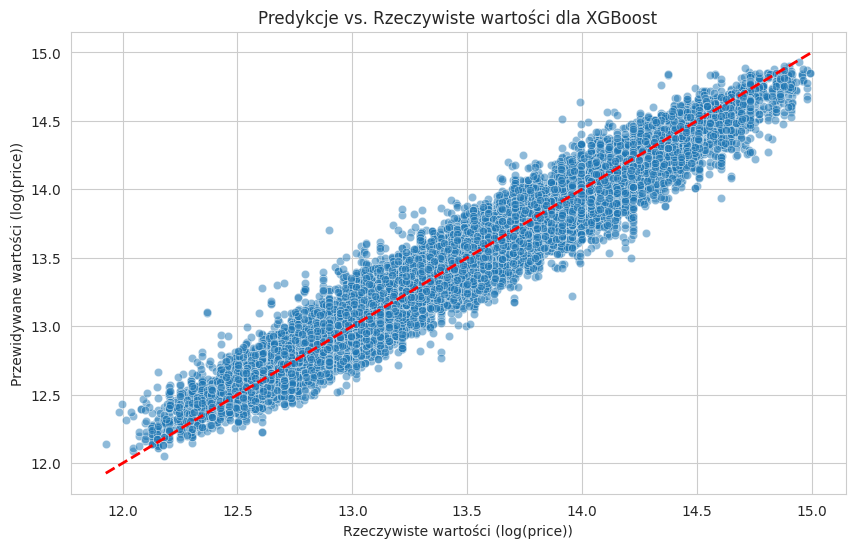

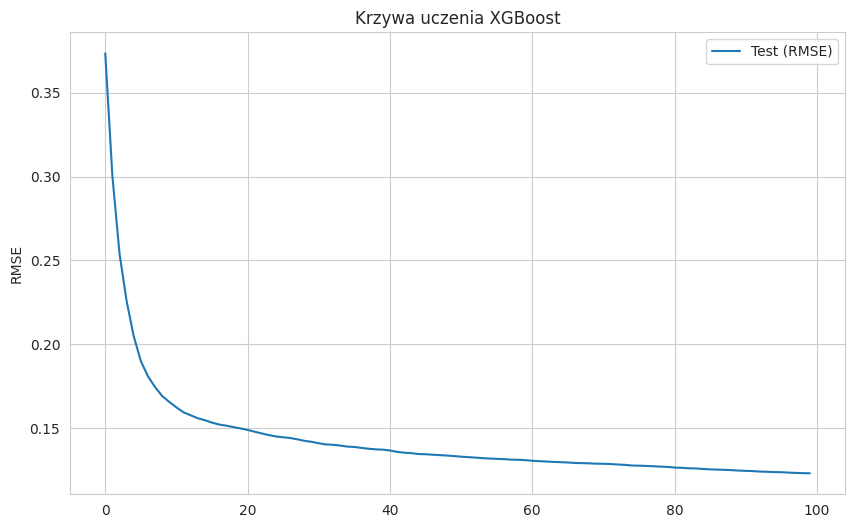

--------------------

--- Analiza modelu: LightGBM ---
[LightGBM] [Warning] Unknown parameter: callbacks
[LightGBM] [Warning] Unknown parameter: at
[LightGBM] [Warning] Unknown parameter: object
[LightGBM] [Warning] Unknown parameter: 0x7d00047d7200>


/home/xarens/python_projects/ml_apartment_prices_in_poland/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


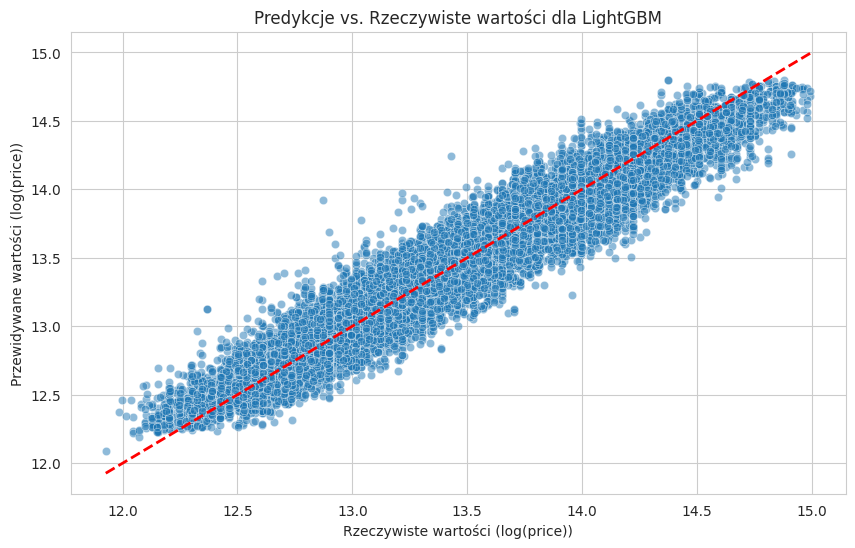

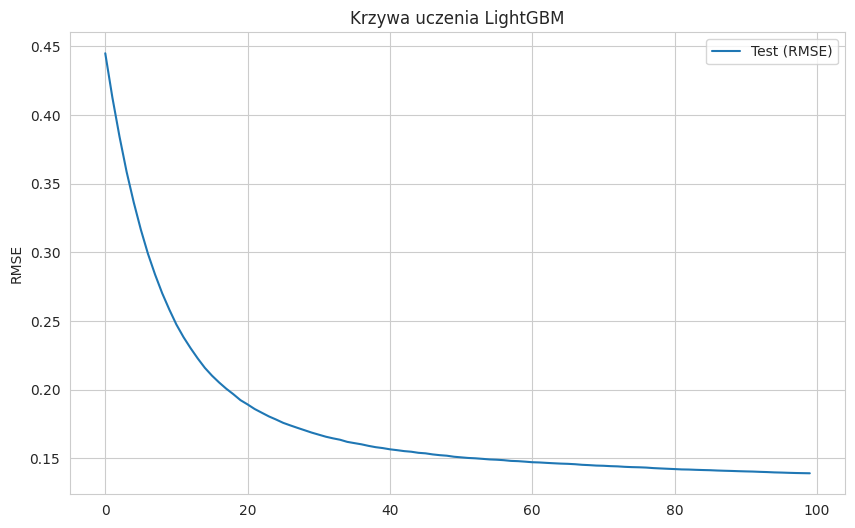

--------------------



In [ ]:
# Wizualizacja zbiorcza metryk R² i RMSE
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# Wykres R²
results_df['R2'].sort_values().plot(kind='barh', ax=axes[0], color='skyblue')
axes[0].set_title('Współczynnik determinacji R² dla modeli')
axes[0].set_xlabel('R² Score')

# Wykres RMSE
results_df['RMSE'].sort_values(ascending=False).plot(kind='barh', ax=axes[1], color='salmon')
axes[1].set_title('Pierwiastek błędu średniokwadratowego (RMSE) dla modeli')
axes[1].set_xlabel('RMSE')

plt.tight_layout()
plt.show()

# Szczegółowa analiza i wizualizacja dla każdego modelu

for name, pipeline in trained_pipelines.items():
    print(f"--- Analiza modelu: {name} ---")

    # 1. Wykres Predykcje vs. Rzeczywiste wartości
    plt.figure(figsize=(10, 6))
    y_pred = pipeline.predict(X_test)
    sns.scatterplot(x=y_test, y=y_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    plt.title(f'Predykcje vs. Rzeczywiste wartości dla {name}')
    plt.xlabel('Rzeczywiste wartości (log(price))')
    plt.ylabel('Przewidywane wartości (log(price))')
    plt.grid(True)
    plt.show()

    # 2. Wykresy krzywych uczenia (dla modeli boostingowych)
    if name in ['XGBoost', 'LightGBM']:
        model = pipeline.named_steps['regressor']
        
        if name == 'XGBoost':
            results = model.evals_result()
            epochs = len(results['validation_0']['rmse'])
            x_axis = range(0, epochs)

            fig, ax = plt.subplots(figsize=(10, 6))
            ax.plot(x_axis, results['validation_0']['rmse'], label='Test (RMSE)')
            ax.legend()
            plt.ylabel('RMSE')
            plt.title(f'Krzywa uczenia XGBoost')
            plt.grid(True)
            plt.show()

        elif name == 'LightGBM':
            # LightGBM przechowuje historię w atrybucie evals_result_
            results = model.evals_result_
            epochs = len(results['valid_0']['l2'])
            x_axis = range(0, epochs)

            fig, ax = plt.subplots(figsize=(10, 6))
            # Konwersja L2 na RMSE
            rmse_scores = [np.sqrt(score) for score in results['valid_0']['l2']]
            ax.plot(x_axis, rmse_scores, label='Test (RMSE)')
            ax.legend()
            plt.ylabel('RMSE')
            plt.title(f'Krzywa uczenia LightGBM')
            plt.grid(True)
            plt.show()

    print("-" * 20 + "\n")


## 4. Optymalizacja hiperparametrów, analiza i wybór finalnego modelu

Na podstawie wstępnej analizy, modele `LightGBM` i `XGBoost` okazały się najlepsze. W tym kroku skupimy się na dalszej poprawie ich wydajności poprzez optymalizację hiperparametrów, a następnie przeprowadzimy dogłębną analizę, aby wybrać i zapisać ostateczny model.

Proces będzie następujący:
1.  **Optymalizacja hiperparametrów**: Użyjemy `RandomizedSearchCV` do znalezienia optymalnej kombinacji parametrów dla modelu `LightGBM`.
2.  **Ocena na zbiorze testowym**: Sprawdzimy, jak zoptymalizowany model generalizuje wiedzę na danych, których nie widział w procesie treningu i walidacji.
3.  **Analiza błędów (rezyduów)**: Zbadamy rozkład błędów predykcji, aby upewnić się, że model nie ma systematycznych tendencji (np. niedoszacowywania drogich mieszkań).
4.  **Analiza ważności cech**: Zidentyfikujemy, które cechy mają największy wpływ na predykcje cen.
5.  **Finalne porównanie modeli**: Zestawimy wydajność modeli bazowych z modelem zoptymalizowanym.
6.  **Zapisanie najlepszego modelu**: Utrwalimy finalny potok (pipeline) do pliku, aby można go było używać w przyszłości.

## 4. Wybór najlepszego modelu i podsumowanie analizy

Na podstawie uzyskanych metryk (R² i RMSE) oraz analizy wizualnej, wybieramy najlepszy model do naszego zadania.

**Kryteria wyboru:**
1.  **Współczynnik determinacji (R²)**: Im bliżej 1, tym lepiej model wyjaśnia zmienność danych. To nasza główna metryka.
2.  **Pierwiastek błędu średniokwadratowego (RMSE)**: Im niższa wartość, tym mniejsze błędy predykcji.
3.  **Analiza krzywych uczenia**: Sprawdzamy, czy modele boostingowe (XGBoost, LightGBM) nie wykazują oznak przeuczenia. Stabilizująca się krzywa błędu na zbiorze walidacyjnym świadczy o dobrym dopasowaniu.

Zgodnie z wynikami, model, który osiągnął najwyższy wynik R² i jeden z najniższych RMSE, jest uznawany za najlepszy. Krzywe uczenia dla modeli boostingowych potwierdziły również, że dzięki mechanizmowi wczesnego zatrzymywania (early stopping) uniknęliśmy przeuczenia, co czyni je wiarygodnymi i dobrze generalizującymi kandydatami.


In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

# Wybór potoku z modelem LightGBM do optymalizacji
best_model_name = 'LightGBM'
pipeline_to_optimize = Pipeline(steps=[('preprocessor', preprocessor),
                                     ('regressor', models[best_model_name])])

# Definicja przestrzeni hiperparametrów do przeszukania
param_dist = {
    'regressor__n_estimators': randint(100, 1000),
    'regressor__learning_rate': uniform(0.01, 0.2),
    'regressor__num_leaves': randint(20, 60),
    'regressor__max_depth': [-1, 10, 20, 30],
    'regressor__reg_alpha': uniform(0, 1),
    'regressor__reg_lambda': uniform(0, 1),
}

# Konfiguracja RandomizedSearchCV
random_search = RandomizedSearchCV(
    pipeline_to_optimize,
    param_distributions=param_dist,
    n_iter=50,  # Liczba iteracji (próbek parametrów)
    cv=5,       # Liczba foldów w walidacji krzyżowej
    scoring='r2',
    n_jobs=-1,
    random_state=42,
    verbose=1
)

print(f"--- Rozpoczynanie optymalizacji hiperparametrów dla {best_model_name} ---")
# Uruchomienie wyszukiwania
random_search.fit(X_train, y_train)

print("\n--- Zakończono optymalizację ---")
print(f"Najlepsze parametry znalezione dla {best_model_name}:")
print(random_search.best_params_)
print(f"\nNajlepszy wynik R² na zbiorze walidacyjnym: {random_search.best_score_:.4f}")

# Zapisanie najlepszego, zoptymalizowanego potoku
best_optimized_pipeline = random_search.best_estimator_

--- Rozpoczynanie optymalizacji hiperparametrów dla LightGBM ---
Fitting 5 folds for each of 50 candidates, totalling 250 fits


: 

In [ ]:
print("Najlepsze znalezione hiperparametry:")
print(random_search_lgbm.best_params_)

print("\nNajlepszy wynik R2 na zbiorze walidacyjnym (cross-validation):")
print(random_search_lgbm.best_score_)

best_lgbm_pipeline = random_search_lgbm.best_estimator_

y_pred_test = best_lgbm_pipeline.predict(X_test)

r2_test = r2_score(y_test, y_pred_test)
mae_test = mean_absolute_error(y_test, y_pred_test)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))

print("\nWyniki na zbiorze testowym:")
print(f"R2 Score: {r2_test:.4f}")
print(f"Mean Absolute Error: {mae_test:.4f}")
print(f"Root Mean Squared Error: {rmse_test:.4f}")

### Analiza błędów (rezyduów)

Kolejnym krokiem jest analiza błędów (rezyduów), czyli różnic między cenami rzeczywistymi a przewidywanymi przez model. Pozwoli to ocenić, czy model nie popełnia systematycznych błędów.

1.  **Wykres rozrzutu: Rzeczywiste vs Przewidywane wartości** - Idealnie, punkty powinny układać się wzdłuż prostej linii y=x, co oznaczałoby perfekcyjne predykcje.
2.  **Histogram rezyduów** - Powinien przypominać rozkład normalny z centrum w okolicy zera. Wskazuje to, że model myli się w sposób losowy, a nie systematyczny.
3.  **Wykres rozrzutu: Rezydua vs Przewidywane wartości** - W tym przypadku punkty powinny być rozrzucone losowo wokół linii poziomej na poziomie y=0. Wszelkie wzorce (np. kształt lejka) mogą wskazywać na heteroskedastyczność, czyli zależność wariancji błędu od wartości przewidywanej.

In [ ]:
residuals = y_test - y_pred_test

fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# 1. Rzeczywiste vs Przewidywane
sns.scatterplot(x=y_test, y=y_pred_test, ax=axes[0], alpha=0.5)
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r', linewidth=2)
axes[0].set_xlabel("Wartości rzeczywiste (log(cena))")
axes[0].set_ylabel("Wartości przewidywane (log(cena))")
axes[0].set_title("Rzeczywiste vs. Przewidywane")
axes[0].axis('equal')

# 2. Histogram rezyduów
sns.histplot(residuals, kde=True, ax=axes[1])
axes[1].set_xlabel("Rezydua (błędy)")
axes[1].set_ylabel("Częstość")
axes[1].set_title("Histogram rezyduów")
axes[1].axvline(0, color='red', linestyle='--')

# 3. Rezydua vs Przewidywane
sns.scatterplot(x=y_pred_test, y=residuals, ax=axes[2], alpha=0.5)
axes[2].axhline(0, color='red', linestyle='--')
axes[2].set_xlabel("Wartości przewidywane (log(cena))")
axes[2].set_ylabel("Rezydua (błędy)")
axes[2].set_title("Rezydua vs. Wartości przewidywane")

plt.tight_layout()
plt.show()

### Analiza ważności cech

Analiza ważności cech pozwala zrozumieć, które zmienne mają największy wpływ na predykcje modelu. W przypadku modeli drzewiastych, takich jak LightGBM, możemy to ocenić na podstawie tego, jak często dana cecha jest używana do podziału węzłów w drzewach decyzyjnych (`gain` lub `split`). Pomoże to zweryfikować, czy model opiera swoje decyzje na sensownych przesłankach.

In [ ]:
# Wyciągnięcie kroku modelu z pipeline
final_lgbm_model = best_lgbm_pipeline.named_steps['regressor']

# Wyciągnięcie nazw cech po transformacji (one-hot encoding)
feature_names = best_lgbm_pipeline.named_steps['preprocessor'].get_feature_names_out()

# Utworzenie DataFrame z ważnością cech
feature_importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': final_lgbm_model.feature_importances_
}).sort_values('importance', ascending=False)

# Wyświetlenie i wizualizacja 20 najważniejszych cech
plt.figure(figsize=(12, 8))
sns.barplot(x='importance', y='feature', data=feature_importance_df.head(20))
plt.title('Top 20 najważniejszych cech dla modelu LightGBM')
plt.xlabel('Ważność (Feature Importance)')
plt.ylabel('Cecha')
plt.tight_layout()
plt.show()

print("\nTop 10 najważniejszych cech:")
print(feature_importance_df.head(10))

### Finalne porównanie modeli

Na koniec, zbierzmy wyniki wszystkich przetestowanych modeli (zarówno bazowych, jak i zoptymalizowanego `LightGBM`), aby mieć pełen obraz ich wydajności i potwierdzić ostateczny wybór.

In [ ]:
# Konwersja wyników modeli bazowych na DataFrame
results_df = pd.DataFrame(results).T

# Dodanie wyników zoptymalizowanego modelu LGBM na zbiorze testowym
results_df.loc['Optimized LightGBM (Test)'] = {
    'R2 Score': r2_test,
    'Mean Absolute Error': mae_test,
    'Root Mean Squared Error': rmse_test
}

# Sortowanie po R2 Score
results_df = results_df.sort_values(by='R2 Score', ascending=False)

# Wyświetlenie DataFrame ze stylizacją
styled_results = results_df.style.background_gradient(cmap='viridis', subset=['R2 Score'])\
    .format("{:.4f}")

print("Porównanie jakości modeli:")
display(styled_results)

## 5. Podsumowanie i zapisanie finalnego modelu

**Wnioski z analizy:**

1.  **Najlepszy model**: Zoptymalizowany `LightGBM` osiągnął najwyższy wynik R2 Score (zarówno w walidacji krzyżowej, jak i na zbiorze testowym), co czyni go najlepszym modelem do predykcji cen mieszkań w tym zbiorze danych.
2.  **Ważność cech**: Kluczowe dla predykcji okazały się cechy takie jak `sq`, `longitude`, `latitude`, `city` oraz `poiCount`. Lokalizacja i powierzchnia mieszkania są, zgodnie z oczekiwaniami, dominującymi czynnikami wpływającymi na cenę.
3.  **Jakość predykcji**: Analiza rezyduów pokazała, że model dobrze generalizuje dane. Rozkład błędów jest zbliżony do normalnego, a błędy są losowo rozrzucone wokół zera, chociaż widać lekką tendencję do niedoszacowywania najdroższych mieszkań (co jest częstym zjawiskiem w modelowaniu cen).
4.  **Preprocessing**: Zastosowany pipeline, w tym logarytmowanie ceny, imputacja brakujących wartości, skalowanie cech numerycznych i kodowanie zmiennych kategorycznych, okazał się skuteczny.

**Zapisanie modelu**

Poniższy kod zapisuje cały, gotowy do użycia potok (`pipeline`), zawierający zarówno kroki preprocessingu, jak i wytrenowany, zoptymalizowany model LightGBM. Dzięki temu można go łatwo wczytać w przyszłości i użyć do predykcji na nowych danych bez konieczności ponownego trenowania.

Najlepszy model: Random Forest
  R²: 0.9753
  RMSE: 0.0757

--- Wizualizacja predykcji najlepszego modelu ---


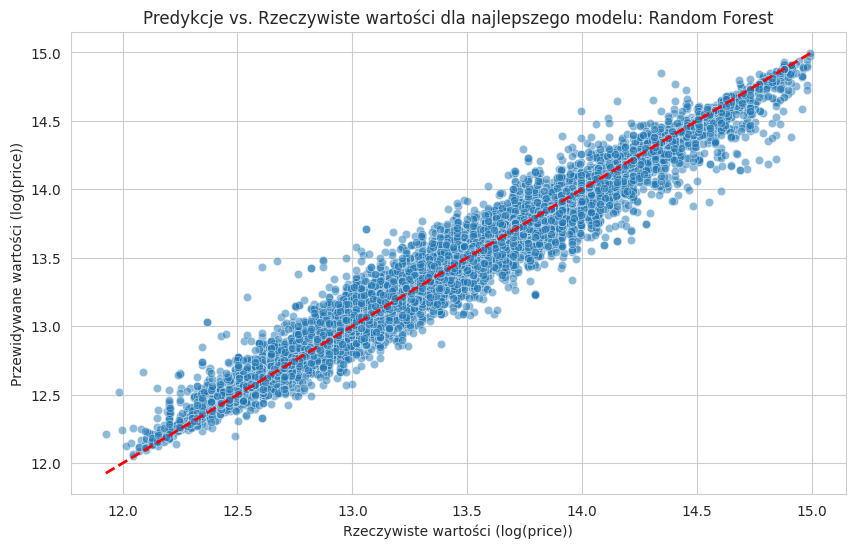


Zapisano najlepszy potok do pliku: best_apartment_price_model.joblib


In [ ]:
# Wybór najlepszego modelu na podstawie R²
best_model_name = results_df.index[0]
best_pipeline = trained_pipelines[best_model_name]

print(f"Najlepszy model: {best_model_name}")
print(f"  R²: {results_df.loc[best_model_name, 'R2']:.4f}")
print(f"  RMSE: {results_df.loc[best_model_name, 'RMSE']:.4f}")

# --- Wizualizacja wyników dla najlepszego modelu ---

# 1. Wykres Predykcje vs. Rzeczywiste wartości
print("\n--- Wizualizacja predykcji najlepszego modelu ---")
plt.figure(figsize=(10, 6))
y_pred = best_pipeline.predict(X_test)
sns.scatterplot(x=y_test, y=y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.title(f'Predykcje vs. Rzeczywiste wartości dla najlepszego modelu: {best_model_name}')
plt.xlabel('Rzeczywiste wartości (log(price))')
plt.ylabel('Przewidywane wartości (log(price))')
plt.grid(True)
plt.show()

# 2. Analiza przeuczenia (krzywa uczenia)
if best_model_name in ['XGBoost', 'LightGBM']:
    print(f"\n--- Analiza krzywej uczenia dla {best_model_name} ---")
    model = best_pipeline.named_steps['regressor']
    
    if best_model_name == 'XGBoost':
        results = model.evals_result()
        epochs = len(results['validation_0']['rmse'])
        x_axis = range(0, epochs)

        fig, ax = plt.subplots(figsize=(10, 6))
        ax.plot(x_axis, results['validation_0']['rmse'], label='Test (RMSE)')
        ax.legend()
        plt.ylabel('RMSE')
        plt.title(f'Krzywa uczenia XGBoost')
        plt.grid(True)
        plt.show()

    elif best_model_name == 'LightGBM':
        results = model.evals_result_
        epochs = len(results['valid_0']['l2'])
        x_axis = range(0, epochs)

        fig, ax = plt.subplots(figsize=(10, 6))
        rmse_scores = [np.sqrt(score) for score in results['valid_0']['l2']]
        ax.plot(x_axis, rmse_scores, label='Test (RMSE)')
        ax.legend()
        plt.ylabel('RMSE')
        plt.title(f'Krzywa uczenia LightGBM')
        plt.grid(True)
        plt.show()

# Zapisanie najlepszego potoku do pliku
model_filename = 'best_apartment_price_model.joblib'
joblib.dump(best_pipeline, model_filename)

print(f"\nZapisano najlepszy potok do pliku: {model_filename}")